In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import ssd300_vgg16
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import numpy as np
from glob import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
from torchvision import transforms
from torchvision.ops import box_iou
import time
import math
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# ============================================================
# PHẦN 1: IMPORT VÀ CẤU HÌNH
# ============================================================
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import ssd300_vgg16
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import numpy as np
from glob import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
from torchvision import transforms
from torchvision.ops import box_iou
import time
import math
from PIL import Image
import matplotlib.pyplot as plt

# Cấu hình
BATCH_SIZE = 8
NUM_EPOCHS = 30
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2  # 1 class biển báo + 1 class background

# Đường dẫn
TRAIN_DIR = '/kaggle/input/build-dataset-tt100k-tsd/tt100k_yolo/images/train'
VAL_DIR = '/kaggle/input/build-dataset-tt100k-tsd/tt100k_yolo/images/test'

# ============================================================
# PHẦN 2: DATASET CLASS (ĐÃ SỬA)
# ============================================================
class YoloDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.imgs = glob(os.path.join(root_dir, '*g'))

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_orig, w_orig = img.shape[:2]

        label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')

        boxes_orig = []  # 🔥 GT boxes ở tọa độ gốc (không resize)
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = list(map(float, line.strip().split()))
                    class_id = int(parts[0])
                    x_c, y_c, bbox_w, bbox_h = parts[1:]

                    # Convert YOLO -> Pascal VOC (tọa độ ảnh gốc)
                    x_min = (x_c - bbox_w / 2) * w_orig
                    y_min = (y_c - bbox_h / 2) * h_orig
                    x_max = (x_c + bbox_w / 2) * w_orig
                    y_max = (y_c + bbox_h / 2) * h_orig
                    
                    # Kẹp giá trị
                    x_min = max(0, min(x_min, w_orig - 1))
                    y_min = max(0, min(y_min, h_orig - 1))
                    x_max = max(0, min(x_max, w_orig - 1))
                    y_max = max(0, min(y_max, h_orig - 1))
                    
                    if x_max > x_min and y_max > y_min:
                        boxes_orig.append([x_min, y_min, x_max, y_max])
                        labels.append(1)

        # 🔥 LƯU GT BOXES GỐC trước khi augment
        boxes_orig_copy = [box.copy() for box in boxes_orig]
        
        # Augmentation CHỈ ÁP DỤNG CHO ẢNH (để train model)
        if self.transforms:
            # Chỉ resize ảnh, KHÔNG transform boxes
            if len(boxes_orig) > 0:
                try:
                    # Dùng boxes để tránh lỗi Albumentations, nhưng sẽ bỏ kết quả
                    transformed = self.transforms(image=img, bboxes=boxes_orig, labels=labels)
                    img = transformed['image']
                    # ❌ KHÔNG dùng transformed['bboxes'] vì đã bị resize
                except ValueError as e:
                    print(f"Warning: Lỗi Augmentation tại ảnh {img_path}, bỏ qua box. Error: {e}")
                    boxes_orig_copy = []
                    labels = []
                    img = A.Compose([A.Resize(640, 640), ToTensorV2()])(image=img)['image']
            else:
                img = A.Compose([A.Resize(640, 640), ToTensorV2()])(image=img)['image']
        
        # 🔥 SỬ DỤNG BOXES GỐC (không bị resize)
        if len(boxes_orig_copy) > 0:
            boxes = torch.as_tensor(boxes_orig_copy, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        img = img.float() / 255.0

        # Tạo target
        target = {}
        target["boxes"] = boxes  # 🔥 Boxes ở tọa độ GỐC
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        
        if len(boxes) > 0:
            target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            target["area"] = torch.as_tensor([], dtype=torch.float32)
            
        target["iscrowd"] = torch.zeros((len(labels),), dtype=torch.int64)
        target["orig_size"] = torch.tensor([h_orig, w_orig], dtype=torch.int64)

        return img, target

    def __len__(self):
        return len(self.imgs)


def collate_fn(batch):
    return tuple(zip(*batch))


# ============================================================
# PHẦN 3: AUGMENTATION
# ============================================================
def get_train_transform():
    return A.Compose([
        A.RandomScale(scale_limit=0.25, p=0.25), 
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.Resize(height=640, width=640),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_val_transform():
    return A.Compose([
        A.Resize(height=640, width=640),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


# ============================================================
# PHẦN 4: DATALOADER
# ============================================================
train_dataset = YoloDataset(TRAIN_DIR, transforms=get_train_transform())
val_dataset = YoloDataset(VAL_DIR, transforms=get_val_transform())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_fn, num_workers=2)


# ============================================================
# PHẦN 5: TRAINING FASTER R-CNN
# ============================================================
def train_faster_rcnn():
    print("=" * 60)
    print("TRAINING FASTER R-CNN RESNET50-FPN")
    print("=" * 60)
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=1e-4, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=True)
        
        for images, targets in loop:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            loop.set_postfix(loss=losses.item())

        lr_scheduler.step()
        print(f"Epoch {epoch+1} Average Loss: {epoch_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), 'faster_rcnn_custom.pth')
    print("✅ Đã lưu model Faster R-CNN!")
    return model


# ============================================================
# PHẦN 6: TRAINING SSD300 VGG16
# ============================================================
def train_ssd():
    print("=" * 60)
    print("TRAINING SSD300 VGG16")
    print("=" * 60)
    
    model = ssd300_vgg16(pretrained_backbone=True, num_classes=NUM_CLASSES, 
                         trainable_backbone_layers=3)
    model.to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=True)
        
        for images, targets in loop:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            loop.set_postfix(loss=losses.item())

        scheduler.step()
        print(f"Epoch {epoch+1} Average Loss: {epoch_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), 'ssd300_vgg16_custom.pth')
    print("✅ Đã lưu model SSD300!")
    return model


# ============================================================
# PHẦN 7: EVALUATION FUNCTIONS (ĐÃ SỬA)
# ============================================================
def weight_size_mb(model: torch.nn.Module) -> float:
    total_bytes = 0
    for p in model.parameters():
        total_bytes += p.numel() * p.element_size()
    for b in model.buffers():
        total_bytes += b.numel() * b.element_size()
    return round(total_bytes / (1024**2), 2)


def compute_ap(recall, precision):
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    recall_points = np.linspace(0, 1, 101)
    precisions_interp = np.interp(recall_points, mrec, mpre)
    return precisions_interp.mean()


@torch.no_grad()
def evaluate_detection_yolo_style(
    model,
    dataloader,
    device="cuda",
    iou_thresholds=np.arange(0.50, 1.00, 0.05),
    model_name="model"
):
    """
    🔥 ĐÃ SỬA: Rescale predictions về kích thước ảnh gốc để so sánh với GT
    """
    model.eval()

    t0 = time.time()
    total_images = 0
    total_infer_ms = 0.0
    total_gts = 0

    all_scores_per_iou = {iou: [] for iou in iou_thresholds}
    all_is_tp_per_iou  = {iou: [] for iou in iou_thresholds}

    pbar = tqdm(dataloader, desc=f"🔍 Evaluating {model_name}", unit="batch")

    for imgs, targets in pbar:
        imgs = [img.to(device) for img in imgs]
        bs = len(imgs)
        total_images += bs

        # Forward + đo thời gian
        t_start = time.time()
        outputs = model(imgs)
        t_end = time.time()

        infer_ms_this_batch = (t_end - t_start) * 1000.0
        total_infer_ms += infer_ms_this_batch

        avg_ms = total_infer_ms / max(total_images, 1)
        pbar.set_postfix({
            "Images": total_images,
            "Avg(ms/img)": f"{avg_ms/bs:.2f}"
        })

        # Xử lý từng ảnh
        for i, (out, tgt) in enumerate(zip(outputs, targets)):
            # Predictions
            if out is None or ("boxes" not in out) or (out["boxes"].numel() == 0):
                pred_boxes = np.zeros((0, 4), dtype=np.float32)
                pred_scores = np.zeros((0,), dtype=np.float32)
            else:
                pred_boxes = out["boxes"].detach().cpu().numpy().astype(np.float32)
                pred_scores = out["scores"].detach().cpu().numpy().astype(np.float32)

            # Ground Truth (đã ở tọa độ ảnh gốc từ Dataset)
            gt_boxes = tgt["boxes"].detach().cpu().numpy().astype(np.float32) if tgt["boxes"].numel() > 0 else np.zeros((0,4), dtype=np.float32)
            
            # 🔥 RESCALE PREDICTIONS VỀ KÍCH THƯỚC GỐC
            input_h, input_w = imgs[i].shape[-2:]  # Kích thước input model (640x640)
            
            # Lấy kích thước gốc từ target
            if "orig_size" in tgt:
                orig_size = tgt["orig_size"]
                if isinstance(orig_size, torch.Tensor):
                    h_orig, w_orig = orig_size[0].item(), orig_size[1].item()
                else:
                    h_orig, w_orig = orig_size[0], orig_size[1]
            else:
                # Fallback: Nếu không có orig_size, giả định không cần scale
                h_orig, w_orig = input_h, input_w
                print(f"⚠️ Warning: Không tìm thấy orig_size trong target!")
            
            # Scale predictions
            if pred_boxes.shape[0] > 0 and (h_orig != input_h or w_orig != input_w):
                scale_x = w_orig / input_w
                scale_y = h_orig / input_h
                
                pred_boxes[:, 0] *= scale_x  # xmin
                pred_boxes[:, 2] *= scale_x  # xmax
                pred_boxes[:, 1] *= scale_y  # ymin
                pred_boxes[:, 3] *= scale_y  # ymax

            # Cập nhật tổng số GT
            total_gts += gt_boxes.shape[0]

            # Sắp xếp predictions
            if pred_scores.shape[0] > 0:
                order = np.argsort(-pred_scores)
                pred_boxes = pred_boxes[order]
                pred_scores = pred_scores[order]

            # Tính TP/FP cho từng IoU threshold
            for iou_t in iou_thresholds:
                if gt_boxes.shape[0] == 0:
                    all_scores_per_iou[iou_t].extend(pred_scores.tolist())
                    all_is_tp_per_iou[iou_t].extend([0] * pred_scores.shape[0])
                    continue
                
                matched_gt = np.zeros(gt_boxes.shape[0], dtype=bool)
                
                if pred_boxes.shape[0] > 0:
                    ious = box_iou(torch.from_numpy(pred_boxes), torch.from_numpy(gt_boxes)).numpy()
                else:
                    ious = np.zeros((0, gt_boxes.shape[0]), dtype=np.float32)

                for d_idx in range(pred_boxes.shape[0]):
                    best_gt = -1
                    best_iou = iou_t
                    
                    for g_idx in range(gt_boxes.shape[0]):
                        if matched_gt[g_idx]:
                            continue
                        iou = ious[d_idx, g_idx]
                        if iou >= best_iou:
                            best_iou = iou
                            best_gt = g_idx
                    
                    is_tp = 0
                    if best_gt >= 0:
                        matched_gt[best_gt] = True
                        is_tp = 1
                    
                    all_scores_per_iou[iou_t].append(float(pred_scores[d_idx]))
                    all_is_tp_per_iou[iou_t].append(int(is_tp))

    # Tính metrics
    if total_gts == 0:
        print("⚠️ Không tìm thấy ground-truth boxes!")
        return {}, {}

    ap_per_iou = {}
    pr_table_for_bestF1 = None

    for iou_t in iou_thresholds:
        scores = np.array(all_scores_per_iou[iou_t], dtype=np.float32)
        is_tp  = np.array(all_is_tp_per_iou[iou_t], dtype=np.int32)

        if scores.size == 0:
            ap_per_iou[iou_t] = 0.0
            if math.isclose(iou_t, 0.50, abs_tol=1e-9):
                pr_table_for_bestF1 = (np.array([0.0]), np.array([0.0]), np.array([1.0]))
            continue

        order = np.argsort(-scores)
        scores = scores[order]
        is_tp = is_tp[order]

        tp_cum = np.cumsum(is_tp)
        fp_cum = np.cumsum(1 - is_tp)
        recall = tp_cum / max(total_gts, 1)
        precision = tp_cum / np.maximum(tp_cum + fp_cum, 1e-9)
        
        ap = compute_ap(recall, precision)
        ap_per_iou[iou_t] = float(ap)

        if math.isclose(iou_t, 0.50, abs_tol=1e-9):
            thresholds = scores.copy()
            pr_table_for_bestF1 = (precision, recall, thresholds)

    mAP50 = float(ap_per_iou.get(0.50, 0.0))
    mAP5095 = float(np.mean(list(ap_per_iou.values()))) if len(ap_per_iou) > 0 else 0.0

    if pr_table_for_bestF1 is not None:
        P_arr, R_arr, Th_arr = pr_table_for_bestF1
        F1_arr = (2 * P_arr * R_arr) / np.clip(P_arr + R_arr, 1e-12, None)
        best_idx = int(np.argmax(F1_arr))
        precision_best = float(P_arr[best_idx])
        recall_best = float(R_arr[best_idx])
        best_conf = float(Th_arr[best_idx])
    else:
        precision_best, recall_best, best_conf = 0.0, 0.0, 1.0

    total_sec = time.time() - t0
    avg_infer_ms = total_infer_ms / max(total_images, 1)
    fps = 1000.0 / max(avg_infer_ms, 1e-9)

    metrics = {
        "Model": model_name,
        "Precision": round(precision_best, 4),
        "Recall": round(recall_best, 4),
        "mAP50": round(mAP50, 4),
        "mAP50-95": round(mAP5095, 4),
        "InferTime(ms)": round(avg_infer_ms, 2),
        "FPS": round(fps, 2),
        "WeightSize(MB)": weight_size_mb(model),
        "EvalTime(min)": round(total_sec / 60.0, 2),
        "BestConf_at_IoU50": round(best_conf, 3),
    }

    details = {
        "AP_per_IoU": {f"{k:.2f}": round(v, 4) for k, v in ap_per_iou.items()},
        "total_images": total_images,
        "total_gts": int(total_gts),
    }

    pbar.close()
    return metrics, details


# ============================================================
# PHẦN 8: INFERENCE VÀ VISUALIZATION
# ============================================================
def visualize_boxes(image, boxes, scores, conf_thresh=0.5):
    vis_img = image.copy()
    for box, score in zip(boxes, scores):
        if score >= conf_thresh:
            x1, y1, x2, y2 = box.astype(int)
            color = (0, 255, 0)
            cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(vis_img, f"{score:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, lineType=cv2.LINE_AA)
    plt.figure(figsize=(10, 8))
    plt.imshow(vis_img)
    plt.axis("off")
    plt.title("📦 Predicted Bounding Boxes")
    plt.show()


def inference_single_image(model, img_path, device="cuda"):
    model.eval()
    
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img_rgb.shape[:2]
    resize_size = 640

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((resize_size, resize_size))
    ])
    img_tensor = transform(Image.fromarray(img_rgb)).to(device)

    with torch.no_grad():
        preds = model([img_tensor])

    pred = preds[0]
    boxes = pred["boxes"].cpu().numpy()
    scores = pred["scores"].cpu().numpy()

    # Scale về ảnh gốc
    scale_x = orig_w / resize_size
    scale_y = orig_h / resize_size
    boxes[:, [0, 2]] *= scale_x
    boxes[:, [1, 3]] *= scale_y

    visualize_boxes(img_rgb, boxes, scores, conf_thresh=0.5)
    return boxes, scores


# ============================================================
# PHẦN 9: MAIN EXECUTION
# ============================================================
# 1. Kiểm tra dataset
print("🔍 Kiểm tra 1 sample từ dataloader...")
imgs, targets = next(iter(val_loader))
tgt = targets[0]
print(f"✅ Target có orig_size: {'orig_size' in tgt}")
if 'orig_size' in tgt:
    print(f"   - orig_size: {tgt['orig_size']}")
print(f"   - GT boxes shape: {tgt['boxes'].shape}")
print(f"   - Input image shape: {imgs[0].shape}")
print()

# 2. Training (comment/uncomment theo nhu cầu)
# model_frcnn = train_faster_rcnn()
# model_ssd = train_ssd()

# 3. Load models để eval
print("🔧 Loading models...")

# Faster R-CNN
model_frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
model_frcnn.load_state_dict(torch.load("/kaggle/input/weight-other-model-tsd-tt100k/pytorch/default/1/faster_rcnn_custom.pth", map_location=DEVICE))
model_frcnn.to(DEVICE)
print("✅ Faster R-CNN loaded!")

# SSD300
model_ssd = ssd300_vgg16(weights=None, num_classes=NUM_CLASSES)
model_ssd.load_state_dict(torch.load("/kaggle/input/weight-other-model-tsd-tt100k/pytorch/default/1/ssd300_vgg16_custom.pth", map_location=DEVICE))
model_ssd.to(DEVICE)
print("✅ SSD300 loaded!")
print()

# 4. Evaluation
print("=" * 60)
print("EVALUATION")
print("=" * 60)

m_frcnn, d_frcnn = evaluate_detection_yolo_style(
    model_frcnn, val_loader, device=DEVICE, model_name="FasterRCNN-R50-FPN"
)
print("\n📊 Faster R-CNN Metrics:")
for k, v in m_frcnn.items():
    print(f"   {k}: {v}")

m_ssd, d_ssd = evaluate_detection_yolo_style(
    model_ssd, val_loader, device=DEVICE, model_name="SSD300-VGG16"
)
print("\n📊 SSD300 Metrics:")
for k, v in m_ssd.items():
    print(f"   {k}: {v}")

# 5. Compare results
print("\n" + "=" * 60)
print("COMPARISON")
print("=" * 60)
import pandas as pd
df = pd.DataFrame([m_frcnn, m_ssd])
print(df.to_string(index=False))



🔍 Kiểm tra 1 sample từ dataloader...
✅ Target có orig_size: True
   - orig_size: tensor([2048, 2048])
   - GT boxes shape: torch.Size([2, 4])
   - Input image shape: torch.Size([3, 640, 640])

🔧 Loading models...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


✅ Faster R-CNN loaded!


Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:05<00:00, 100MB/s] 


✅ SSD300 loaded!

EVALUATION


🔍 Evaluating FasterRCNN-R50-FPN: 100%|██████████| 378/378 [02:51<00:00,  2.21batch/s, Images=3022, Avg(ms/img)=7.77]



📊 Faster R-CNN Metrics:
   Model: FasterRCNN-R50-FPN
   Precision: 0.7478
   Recall: 0.6588
   mAP50: 0.7332
   mAP50-95: 0.4754
   InferTime(ms): 46.64
   FPS: 21.44
   WeightSize(MB): 157.95
   EvalTime(min): 2.87
   BestConf_at_IoU50: 0.736


🔍 Evaluating SSD300-VGG16: 100%|██████████| 378/378 [01:14<00:00,  5.08batch/s, Images=3022, Avg(ms/img)=1.71]



📊 SSD300 Metrics:
   Model: SSD300-VGG16
   Precision: 0.4807
   Recall: 0.3156
   mAP50: 0.3642
   mAP50-95: 0.1894
   InferTime(ms): 10.23
   FPS: 97.71
   WeightSize(MB): 90.58
   EvalTime(min): 1.24
   BestConf_at_IoU50: 0.053

COMPARISON
             Model  Precision  Recall  mAP50  mAP50-95  InferTime(ms)   FPS  WeightSize(MB)  EvalTime(min)  BestConf_at_IoU50
FasterRCNN-R50-FPN     0.7478  0.6588 0.7332    0.4754          46.64 21.44          157.95           2.87              0.736
      SSD300-VGG16     0.4807  0.3156 0.3642    0.1894          10.23 97.71           90.58           1.24              0.053



🖼️ Testing inference on single image...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


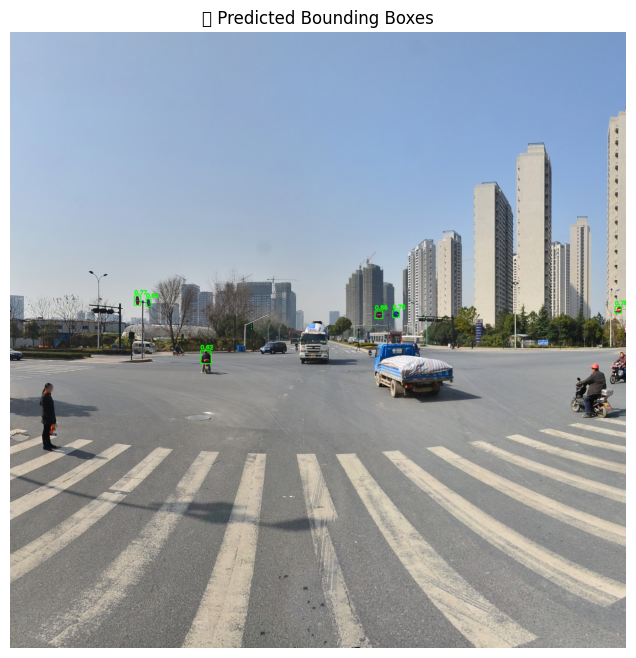

In [3]:
# 6. Test inference trên 1 ảnh
test_img_path = "/kaggle/input/build-dataset-tt100k-tsd/tt100k_yolo/images/test/10056.jpg"
if os.path.exists(test_img_path):
    print("\n🖼️ Testing inference on single image...")
    inference_single_image(model_frcnn, test_img_path, device=DEVICE)


🖼️ Testing inference on single image...


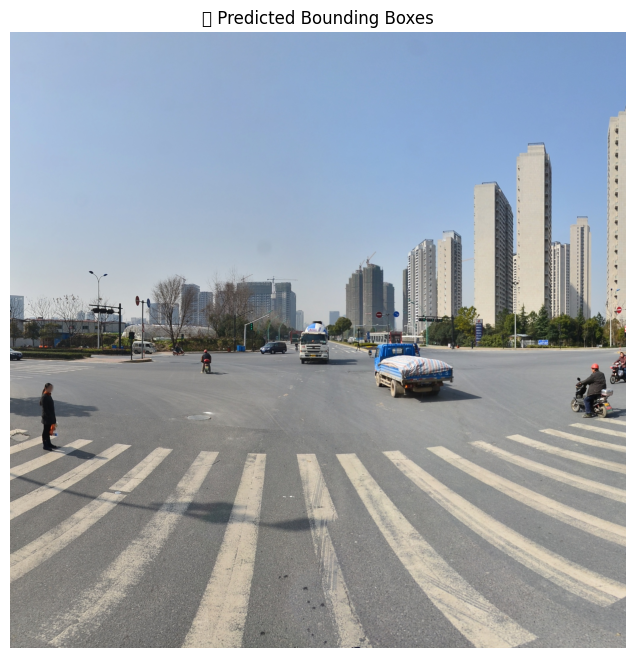

In [4]:
# 7. Test inference trên 1 ảnh
test_img_path = "/kaggle/input/build-dataset-tt100k-tsd/tt100k_yolo/images/test/10056.jpg"
if os.path.exists(test_img_path):
    print("\n🖼️ Testing inference on single image...")
    inference_single_image(model_ssd, test_img_path, device=DEVICE)